In [354]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split, GridSearchCV
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor




In [355]:
# Step 2: Setting Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Step 3: Loading and Preprocessing Data
data = pd.read_csv('merged_data.csv_2.csv')
data.drop(columns=['Nearby_POI_Weight'], inplace=True)
data = data.sample(frac=0.1, random_state=42)

# Handling outliers in the target
z_scores = np.abs((data['Loyer médian (€/m²)'] - data['Loyer médian (€/m²)'].mean()) / data['Loyer médian (€/m²)'].std())
data = data[z_scores <= 3]

# Ensuring target is numeric
data['Loyer médian (€/m²)'] = data['Loyer médian (€/m²)'].astype(float)


Using device: cuda


In [356]:
# Defining features and target
text_features = ['cle_interop', 'commune_nom', 'voie_nom', 'Adresse']
categorical_features = ['Nombre de pièces', 'Époque de construction', 'Type de location']
numerical_features = [
    'lat', 'long','numero', 'num_dentist', 'num_driving_school', 'num_park',
    'num_fitness_centre', 'num_pub', 'num_community_centre',
    'num_yoga_studio', 'num_dojo', 'num_sports_centre','num_bank','num_restaurant','num_library','num_cafe','num_clinic','num_theatre','num_cinema','num_marketplace','num_university','num_childcare','Loyer minimum (€/m²)','Loyer maximum (€/m²)'
]
target = 'Loyer médian (€/m²)'
# Apply log transformation to numerical features
for feature in data[numerical_features]:
    data[f'log_{feature}'] = np.log1p(data[feature])

X_text = data[text_features]
X_num = data[numerical_features]
y = data[target]


# Separating features and target
X_text = data[text_features]
X_categorical = data[categorical_features]
X_numerical = data[numerical_features]
y = data[target]



# Combining text and numerical features into a single dataset
X_combined = pd.concat([X_text,X_categorical, X_numerical], axis=1)


# Splitting combined data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

# Separating  back into components for preprocessing
X_train_text = X_train[text_features]
X_train_categorical = X_train[categorical_features]
X_train_numerical = X_train[numerical_features]

X_test_text = X_test[text_features]
X_test_categorical = X_test[categorical_features]
X_test_numerical = X_test[numerical_features]

In [357]:
data.head()

,cle_interop,commune_nom,voie_nom,numero,long,lat,Adresse,Nombre de pièces,Époque de construction,Type de location,...,log_num_library,log_num_cafe,log_num_clinic,log_num_theatre,log_num_cinema,log_num_marketplace,log_num_university,log_num_childcare,log_Loyer minimum (€/m²),log_Loyer maximum (€/m²)
117469,75109_5741_00016,Paris,Rue de Londres,16,2.329123,48.877226,"Rue de Londres, 75109 Paris",4 pièces et plus,après 1990,non meublée,...,0.000000,3.367296,0.000000,1.609438,0.693147,0.000000,0.0,0.693147,2.850707,3.367296
62097,75111_6858_00104,Paris,Rue Oberkampf,104,2.378514,48.865851,"Rue Oberkampf, 75111 Paris",3 pièces,après 1990,non meublée,...,0.000000,3.583519,0.000000,1.791759,0.000000,0.693147,0.0,0.693147,2.815409,3.328627
25856,75116_9107_00074,Paris,Boulevard Suchet,74,2.262605,48.854523,"Boulevard Suchet, 75116 Paris",2 pièces,après 1990,meublée,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,2.980619,3.496508
16899,75110_4514_00010,Paris,Passage Hébrard,10,2.372380,48.872849,"Passage Hébrard, 75110 Paris",1 pièce,1971-1990,non meublée,...,1.098612,3.555348,0.693147,1.609438,0.000000,0.693147,0.0,1.098612,2.990720,3.508556
143010,75119_9058_00017,Paris,Cours du Septième Art,17,2.386165,48.878123,"Cours du Septième Art, 75119 Paris",1 pièce,1971-1990,meublée,...,0.693147,2.302585,0.000000,1.098612,0.000000,0.000000,0.0,1.791759,2.995732,3.514526


In [358]:

# Initializing TextVectorization for text features
text_vectorizer = TextVectorization(output_mode="tf-idf", max_tokens=10000)

# Preparing text data for vectorization
text_data_train = X_train[text_features].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
text_data_test = X_test[text_features].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

# Adapting TextVectorization layer
text_vectorizer.adapt(tf.convert_to_tensor(text_data_train))

# Vectorizing text features
X_train_text_vectorized = text_vectorizer(tf.convert_to_tensor(text_data_train)).numpy()
X_test_text_vectorized = text_vectorizer(tf.convert_to_tensor(text_data_test)).numpy()

# Encoding categorical features
categorical_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_train_categorical_encoded = categorical_encoder.fit_transform(X_train[categorical_features])
X_test_categorical_encoded = categorical_encoder.transform(X_test[categorical_features])

# Scaling numerical features
scaler = StandardScaler()
X_train_numerical_scaled = scaler.fit_transform(X_train[numerical_features])
X_test_numerical_scaled = scaler.transform(X_test[numerical_features])

# Ensuring all data types are float32 for TensorFlow compatibility
X_train_categorical_encoded = tf.convert_to_tensor(X_train_categorical_encoded, dtype=tf.float32)
X_test_categorical_encoded = tf.convert_to_tensor(X_test_categorical_encoded, dtype=tf.float32)
X_train_numerical_scaled = tf.convert_to_tensor(X_train_numerical_scaled, dtype=tf.float32)
X_test_numerical_scaled = tf.convert_to_tensor(X_test_numerical_scaled, dtype=tf.float32)
X_train_text_vectorized = tf.convert_to_tensor(X_train_text_vectorized, dtype=tf.float32)
X_test_text_vectorized = tf.convert_to_tensor(X_test_text_vectorized, dtype=tf.float32)

# Combine all features and convert to NumPy arrays
X_train_combined = np.hstack([
    X_train_numerical_scaled.numpy(),
    X_train_text_vectorized.numpy(),
    X_train_categorical_encoded.numpy()
])

X_test_combined = np.hstack([
    X_test_numerical_scaled.numpy(),
    X_test_text_vectorized.numpy(),
    X_test_categorical_encoded.numpy()
])

# Converting target to NumPy arrays
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

print(f"Shape of combined training features: {X_train_combined.shape}")
print(f"Shape of combined testing features: {X_test_combined.shape}")


Shape of combined training features: (12179, 4264)
Shape of combined testing features: (3045, 4264)


In [359]:
# Step 5: Creating PyTorch Dataset
class RentDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets.values, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = RentDataset(X_train_combined, y_train)
test_dataset = RentDataset(X_test_combined, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [360]:
# Step 6: Defining the Model
class RentPredictionModel(nn.Module):
    def __init__(self, input_dim):
        super(RentPredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.output(x)
        return x

#  model
input_dim = X_train_combined.shape[1]
model = RentPredictionModel(input_dim).to(device)


In [361]:
def accuracy_within_tolerance(predictions, targets, tolerance=0):
    """
    Calculate the accuracy for regression as the percentage of predictions
    within a certain tolerance of the actual values.
    
    Args:
        predictions (array-like): Predicted values.
        targets (array-like): Actual values.
        tolerance (float): Proportion of the target value to use as tolerance.
        
    Returns:
        float: Accuracy as a percentage.
    """
    absolute_error = np.abs(predictions - targets)
    tolerance_value = tolerance * targets
    accurate_predictions = (absolute_error <= tolerance_value).sum()
    accuracy = accurate_predictions / len(targets)
    return accuracy


Epoch 1/10 - train_loss: 402.4831 - train_mae: 17.9172 -  train_mse: 402.4831 -val_loss: 12.7125 - val_mae: 2.7898- val_mse: 12.7125
Validation Accuracy: 53.63%
Epoch 2/10 - train_loss: 13.5073 - train_mae: 2.9072 -  train_mse: 13.5073 -val_loss: 1.5572 - val_mae: 0.8879- val_mse: 1.5572
Validation Accuracy: 95.07%
Epoch 3/10 - train_loss: 9.7458 - train_mae: 2.4797 -  train_mse: 9.7458 -val_loss: 0.8851 - val_mae: 0.6833- val_mse: 0.8851
Validation Accuracy: 98.10%
Epoch 4/10 - train_loss: 9.0903 - train_mae: 2.3926 -  train_mse: 9.0903 -val_loss: 1.0043 - val_mae: 0.7673- val_mse: 1.0043
Validation Accuracy: 98.75%
Epoch 5/10 - train_loss: 9.0202 - train_mae: 2.3763 -  train_mse: 9.0202 -val_loss: 0.6639 - val_mae: 0.6057- val_mse: 0.6639
Validation Accuracy: 99.41%
Epoch 6/10 - train_loss: 8.9210 - train_mae: 2.3723 -  train_mse: 8.9210 -val_loss: 0.7200 - val_mae: 0.6315- val_mse: 0.7200
Validation Accuracy: 99.11%
Epoch 7/10 - train_loss: 8.6470 - train_mae: 2.3295 -  train_mse: 8

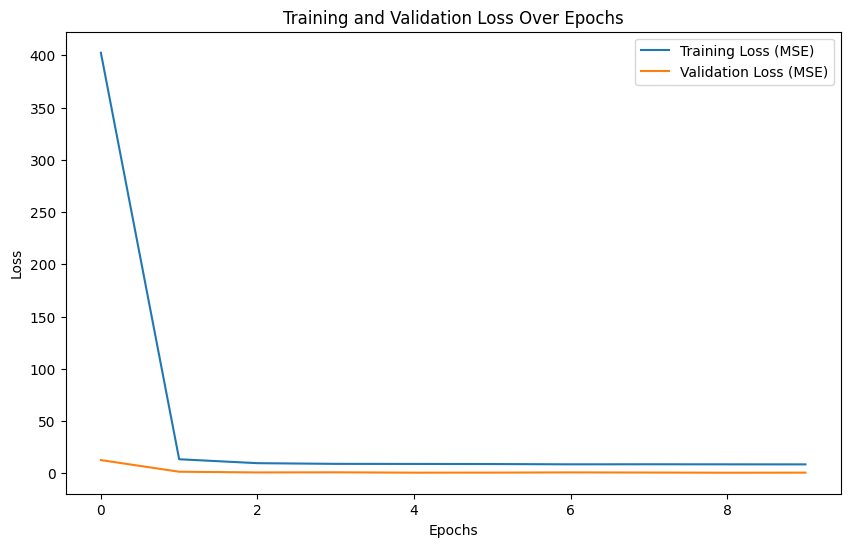

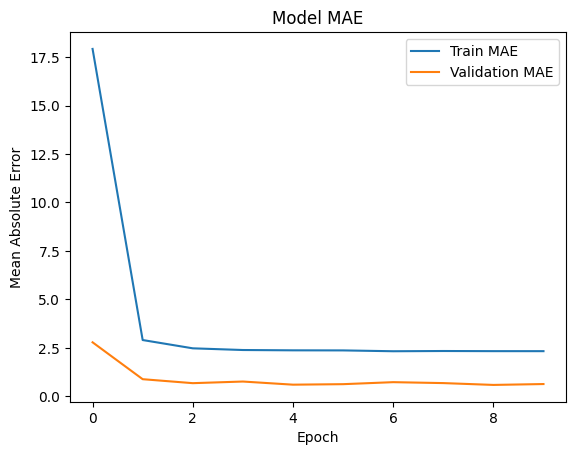

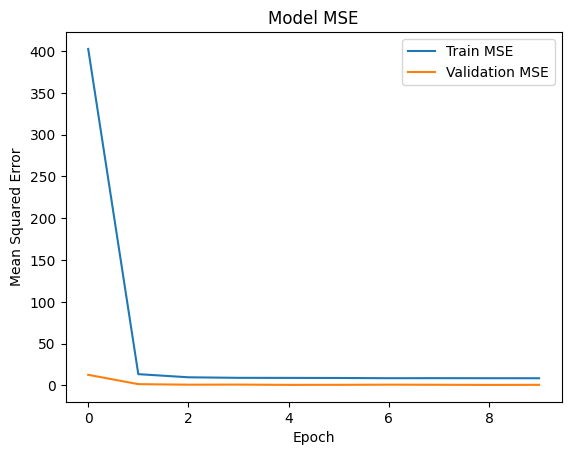

In [362]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    model.to(device)
    history = {"train_loss": [], "train_mae": [], "train_mse": [],"val_loss": [], "val_mae": [],"val_mse": []}
    
    mae_loss = nn.L1Loss()  # Mean Absolute Error Loss
    mse_loss = nn.MSELoss() # Mean Squared Error Loss

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss = 0.0
        train_mae = 0.0
        train_mse = 0.0

        for batch_idx, (features, targets) in enumerate(train_loader):
            features, targets = features.to(device), targets.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(features).squeeze()
            loss = criterion(outputs, targets)
            mae = mae_loss(outputs, targets)
            mse = mse_loss(outputs,targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss and mae
            train_loss += loss.item()
            train_mae += mae.item()
            train_mse += mse.item()

        # average training loss and MAE
        avg_train_loss = train_loss / len(train_loader)
        avg_train_mae = train_mae / len(train_loader)
        avg_train_mse = train_mse / len(train_loader)

        history["train_loss"].append(avg_train_loss)
        history["train_mae"].append(avg_train_mae)
        history["train_mse"].append(avg_train_mse)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_mae = 0.0
        val_mse = 0.0
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features).squeeze()
                loss = criterion(outputs, targets)
                mae = mae_loss(outputs, targets)
                mse = mse_loss(outputs,targets)

                val_loss += loss.item()
                val_mae += mae.item()
                val_mse += mse.item()

                # predictions and targets for evaluation
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())
               

        # average validation loss and MAE
        avg_val_loss = val_loss / len(val_loader)
        avg_val_mae = val_mae / len(val_loader)
        avg_val_mse = val_mse / len(val_loader)

        history["val_loss"].append(avg_val_loss)
        history["val_mae"].append(avg_val_mae)
        history["val_mse"].append(avg_val_mse)

        # Print metrics
        print(
            f"Epoch {epoch + 1}/{epochs} - train_loss: {avg_train_loss:.4f} - train_mae: {avg_train_mae:.4f} -  train_mse: {avg_train_mse:.4f} -"
            f"val_loss: {avg_val_loss:.4f} - val_mae: {avg_val_mae:.4f}- val_mse: {avg_val_mse:.4f}"
        )
        # accuracy metric
        accuracy = accuracy_within_tolerance(np.array(val_predictions), np.array(val_targets), tolerance=0.1)

        print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    # Final Evaluation on Validation Data
    mae = mean_absolute_error(val_targets, val_predictions)
    mse = mean_squared_error(val_targets, val_predictions)
    r2 = r2_score(val_targets, val_predictions)


    print(f"\nFinal Evaluation on Validation Data:")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R²: {r2:.4f}")

    return history


# Training the model and storing the history
# Defining optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=5e-5)  # Adjust learning rate as needed
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
history = train_model(model, train_loader, test_loader, optimizer, criterion, epochs=10)


# training and validation MSE 
plt.figure(figsize=(10, 6))
plt.plot(history["train_loss"], label="Training Loss (MSE)")
plt.plot(history["val_loss"], label="Validation Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.show()

# training and validation MAE
plt.plot(history["train_mae"], label='Train MAE')
plt.plot(history["val_mae"], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


# training and validation MSE
plt.plot(history["train_mse"], label='Train MSE')
plt.plot(history["val_mse"], label='Validation MSE')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


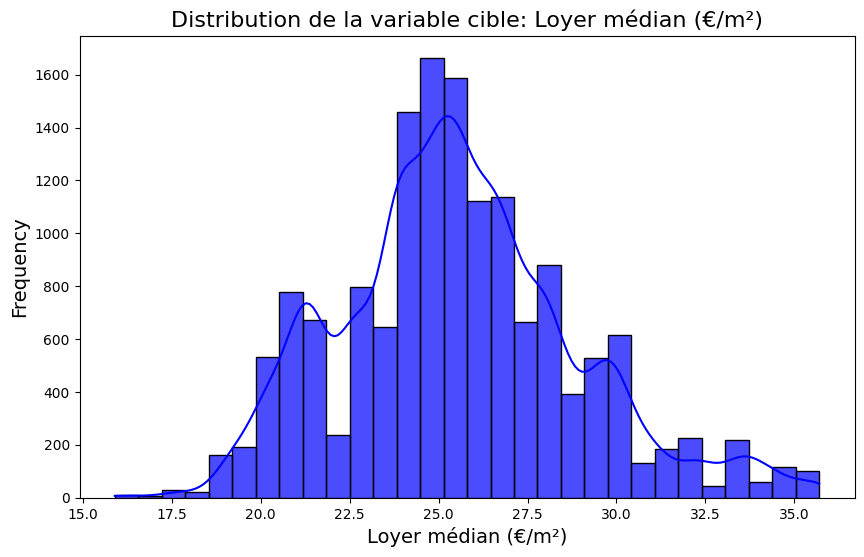

In [363]:
# histogram with KDE for the target variable
plt.figure(figsize=(10, 6))
sns.histplot(data['Loyer médian (€/m²)'], kde=True, bins=30, color='blue', alpha=0.7)

plt.title('Distribution de la variable cible: Loyer médian (€/m²)', fontsize=16)
plt.xlabel('Loyer médian (€/m²)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)


plt.show()


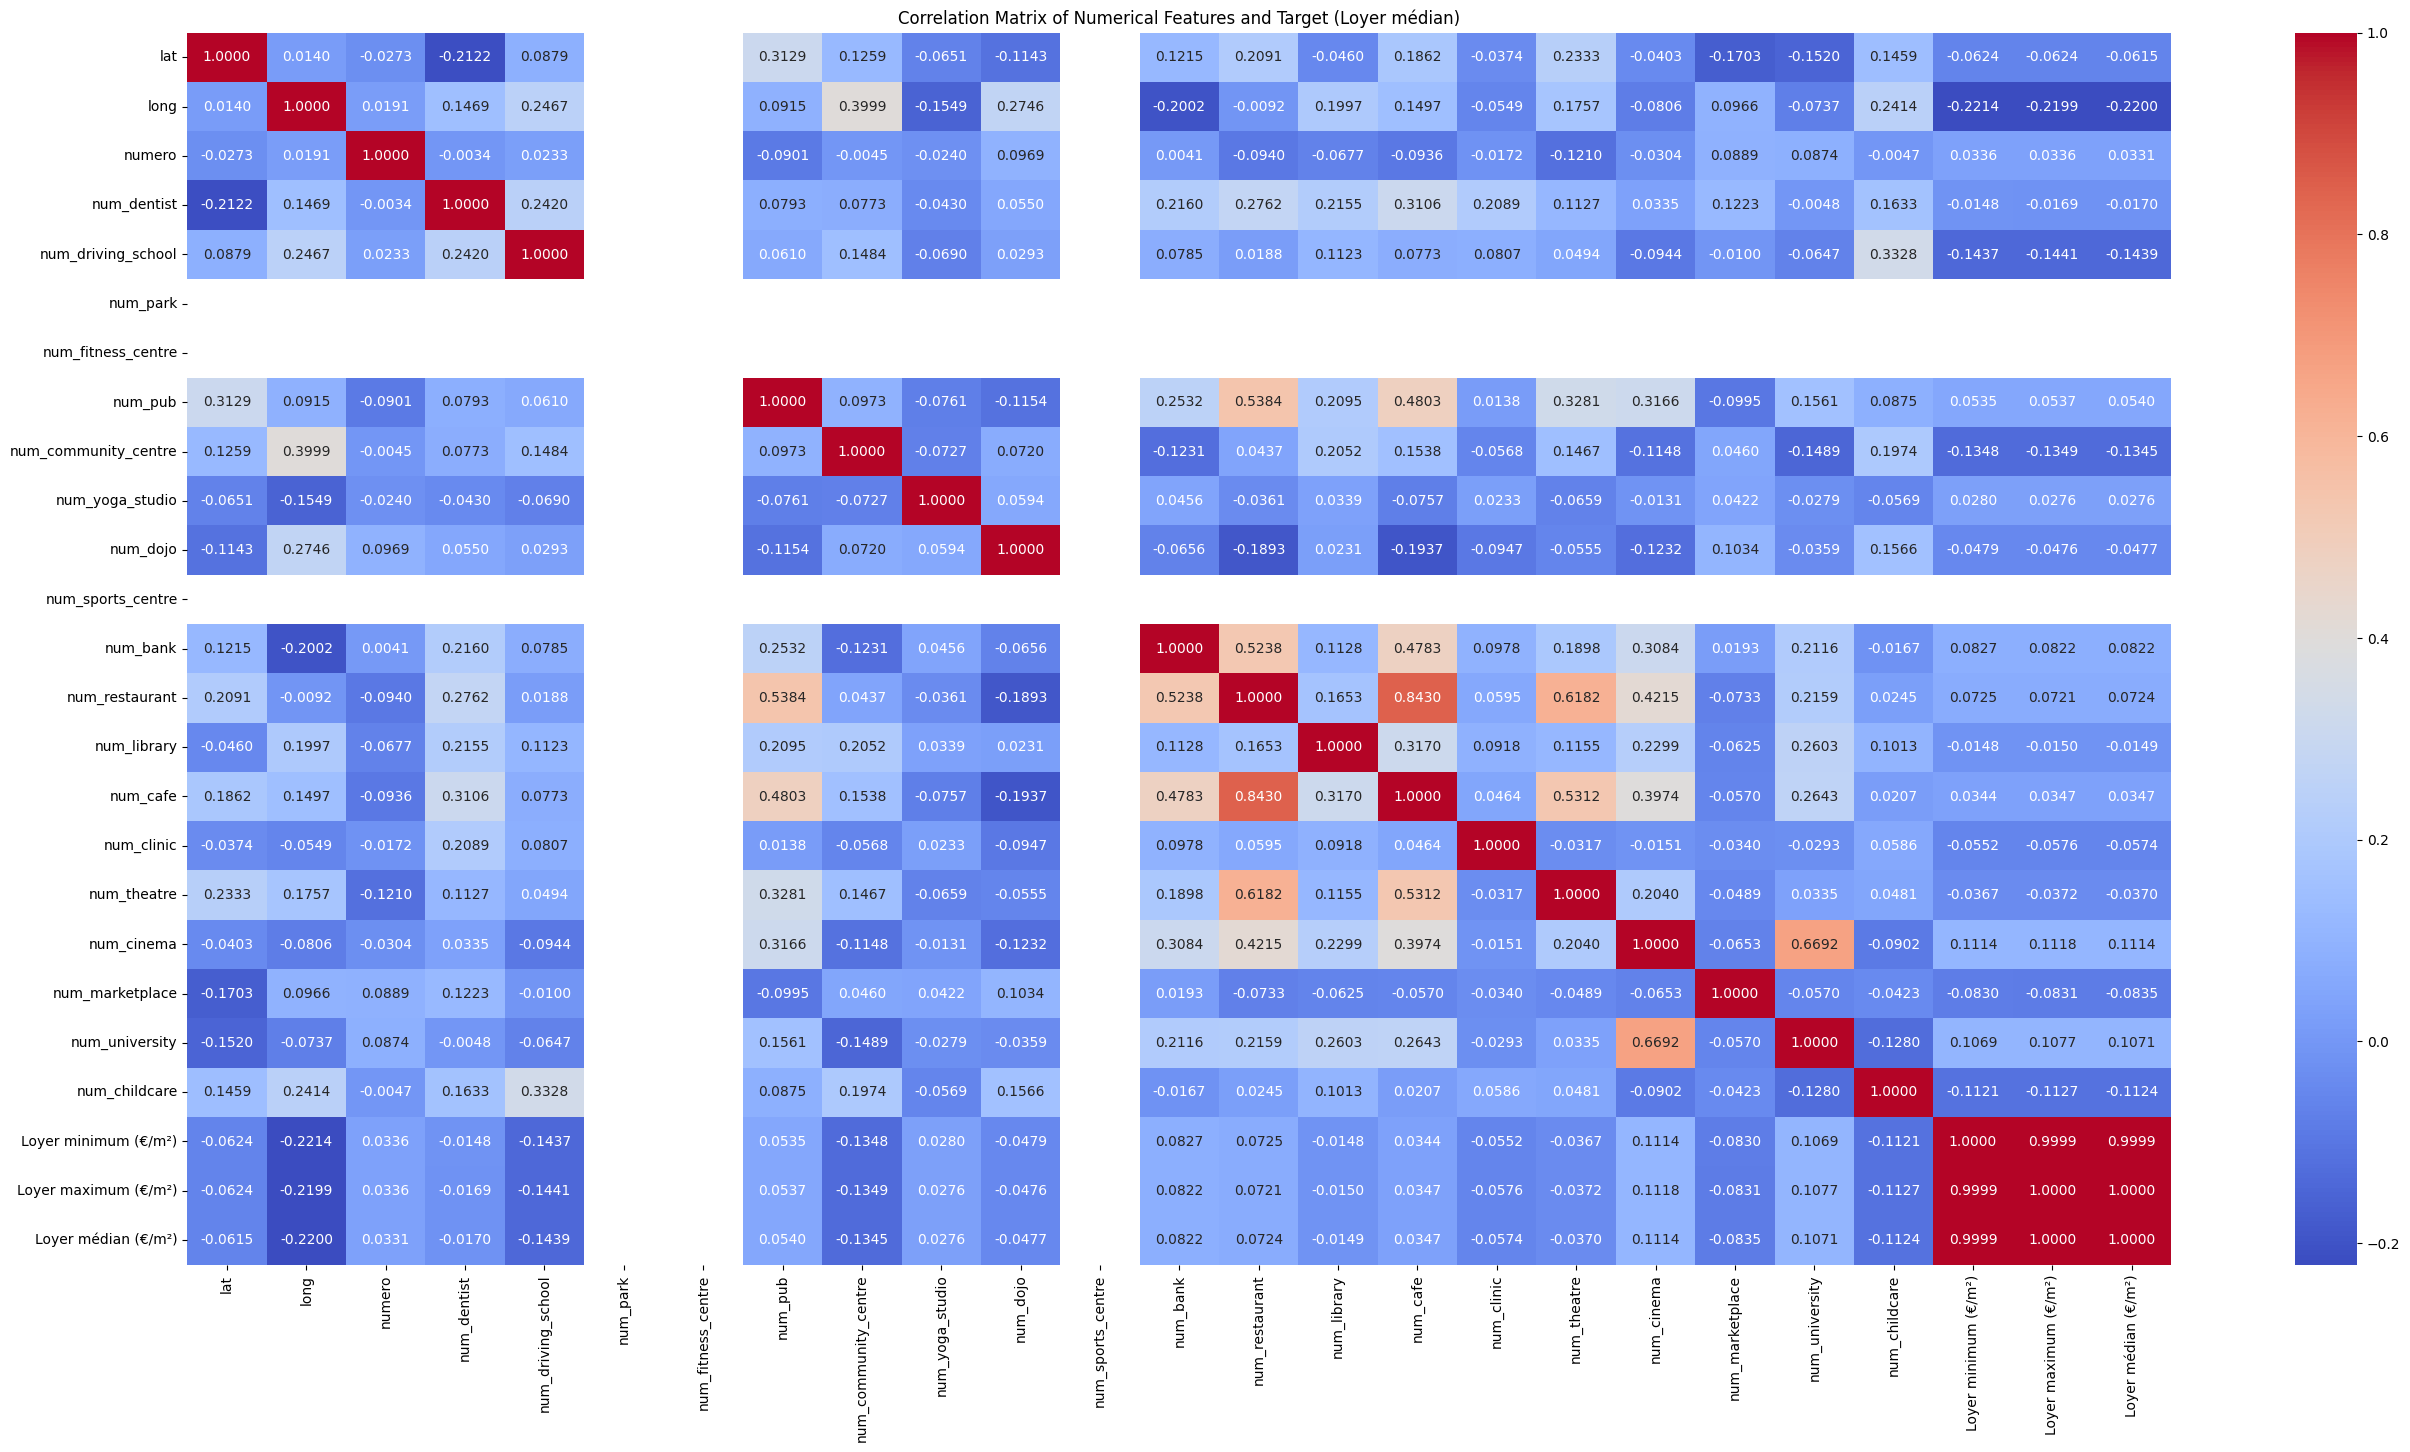

In [364]:
# Compute correlation matrix on the numerical features and target column
correlation_data = data[numerical_features + [target]]
correlation_matrix = correlation_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(32, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".4f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Numerical Features and Target (Loyer médian)")
plt.show()


In [366]:
import torch.onnx

# Save the PyTorch model to ONNX format
torch.onnx.export(
    model,                              # PyTorch model
    torch.randn(1, input_dim).to(device),  # Example input tensor
    "rent_prediction_model.onnx",       # ONNX file path
    export_params=True,                 # Store the trained parameters
    opset_version=12,                   # ONNX opset version
    do_constant_folding=True            # Optimize the graph
)

print("Model exported to ONNX format: 'rent_prediction_model.onnx'")


Model exported to ONNX format: 'rent_prediction_model.onnx'
